# Определение стоимости автомобилей с пробегом.

Сервис по продаже автомобилей с пробегом  разрабатывает приложение для привлечения новых клиентов. В нём можно будет быстро узнать рыночную стоимость своего автомобиля.

**Задача:**  
Потстроение модели определяющей стоимость подержанного автомобиля

**Данные:**  
Исторические данные содержащие технические характеристики и цену проданных автомобилей.

**Заказчику важны:**
- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Импорт

In [20]:
import pandas as pd
import io
import matplotlib.pyplot as plt
import sklearn
import phik
from phik.report import plot_correlation_matrix
from phik import phik_matrix
from time import time

from sklearn.model_selection import train_test_split
# pipe
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# модели
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor 

# тюнинг гиперпараметров
from optuna_integration import LightGBMTunerCV
from optuna_integration import OptunaSearchCV
from optuna import distributions

# crossval
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold


#метрики
from sklearn.metrics import mean_squared_error

### Константы

In [22]:
SZ_1 = (17,5) #size of the plots
RANDOM_STATE = 0

### Настройки

In [24]:
plt.rcParams["figure.figsize"] = SZ_1

### Загрузка данных

In [26]:
df = pd.read_csv('autos.csv')

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [28]:
df.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
77187,2016-03-15 14:47:50,15500,NaN,1990,manual,315,5er,100000,0,petrol,bmw,NaN,2016-03-15 00:00:00,0,46244,2016-03-15 14:47:50
6958,2016-03-24 12:54:47,1000,bus,1999,manual,115,alhambra,150000,0,NaN,seat,NaN,2016-03-24 00:00:00,0,19079,2016-04-07 03:46:41
319435,2016-04-07 01:36:18,599,small,1996,NaN,45,polo,150000,6,petrol,volkswagen,NaN,2016-04-07 00:00:00,0,48527,2016-04-07 01:36:18
28854,2016-03-16 20:50:21,11500,NaN,2017,manual,131,NaN,150000,5,NaN,opel,NaN,2016-03-16 00:00:00,0,23816,2016-04-07 07:45:45
108695,2016-03-17 19:48:55,12200,bus,2014,manual,95,b_max,30000,1,gasoline,ford,no,2016-03-17 00:00:00,0,13053,2016-03-19 20:15:22


Признаки `DateCreated`, `NumberOfPictures`, `PostalCode`, `LastSeen`, `DateCrawled` не значимы для данной задачи так как не связаны со стоимостью автомобиля и могут быть удалены.

In [30]:
date_crawled = df['DateCrawled'].astype('datetime64').max()
df=df.drop(['DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'DateCrawled', 'RegistrationMonth'], axis=1)


Изучение пропущенных значений

Данных без пропусках во всех признаках: 245814 69.37%


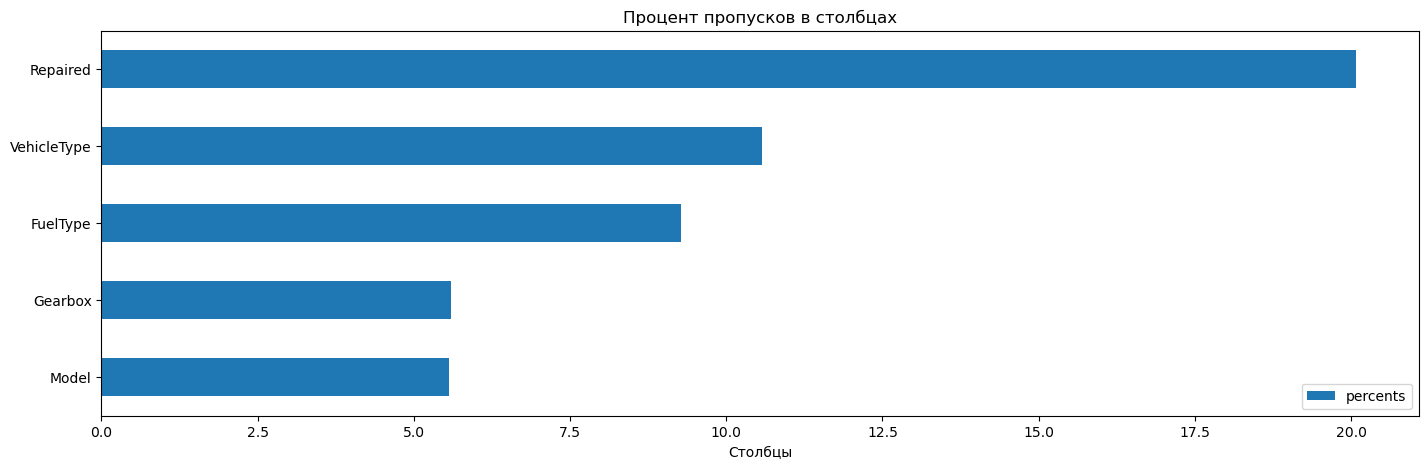

In [32]:
print(f'Данных без пропусках во всех признаках: {(t:=df.dropna().shape[0])} {t/df.shape[0]:.2%}')
((df.isna().mean()*100)
.to_frame()
.rename(columns={0:'percents'})
.query('percents>0')\
.sort_values(by='percents')
.plot(kind = 'barh', title='Процент пропусков в столбцах', xlabel='Столбцы')
);
#s.where(s>0).dropna().plot(kind='barh', xlabel='Кол-во пропусков в %');

Больше данных пропущено в признаке `Repaired`, суммарно пропуски есть чуть больше чем в 30% данных

Изучение распределения признаков


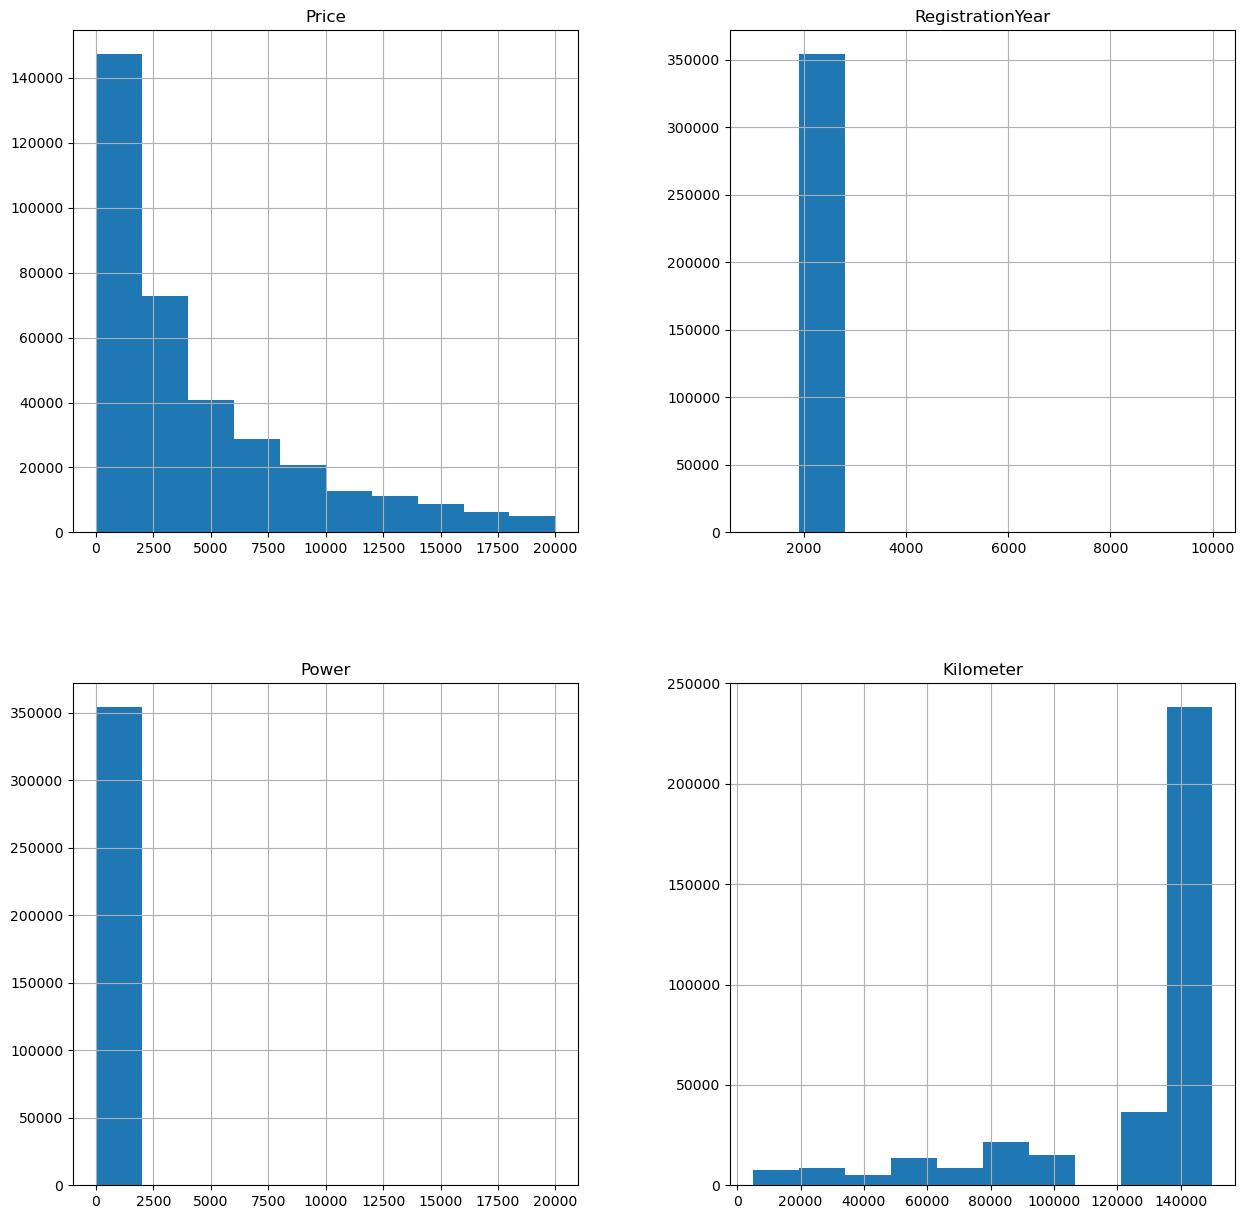

In [35]:
df.hist(figsize=(15,15));

Распределения странные, очевидно наличие выбросов. От них следует избавится.

***

Пропусков: 10.58%


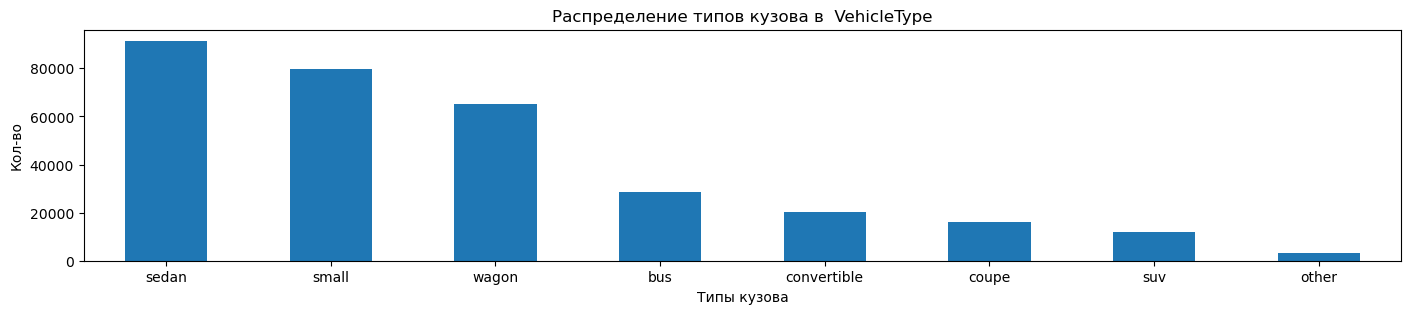

In [38]:
print(f'Пропусков: {df["VehicleType"].isna().mean():.2%}')
df['VehicleType'].value_counts().plot(
    kind='bar',
    figsize=(17,3), 
    rot=0, 
    title='Распределение типов кузова в  VehicleType',
    xlabel = 'Типы кузова',
    ylabel = 'Кол-во'
);

***

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
1%         1980.000000
25%        1999.000000
50%        2003.000000
max        9999.000000
Name: RegistrationYear, dtype: float64
[1000 1001 1039 1111 1200 1234 1253 1255 1300 1400 1500 1600 1602 1688
 1800 1910 1915 1919 1920 1923 1925 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962
 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976
 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990
 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2066 2200 2222 2290 2500 2800 2900 3000 3200 3500 3700 3800 4000
 4100 4500 4800 5000 5300 5555 5600 5900 5911 6000 6500 7000 7100 7500
 7800 8000 8200 8455 8500 8888 9000 9229 9450 9996 9999]


RegistrationYear    315792
dtype: int64

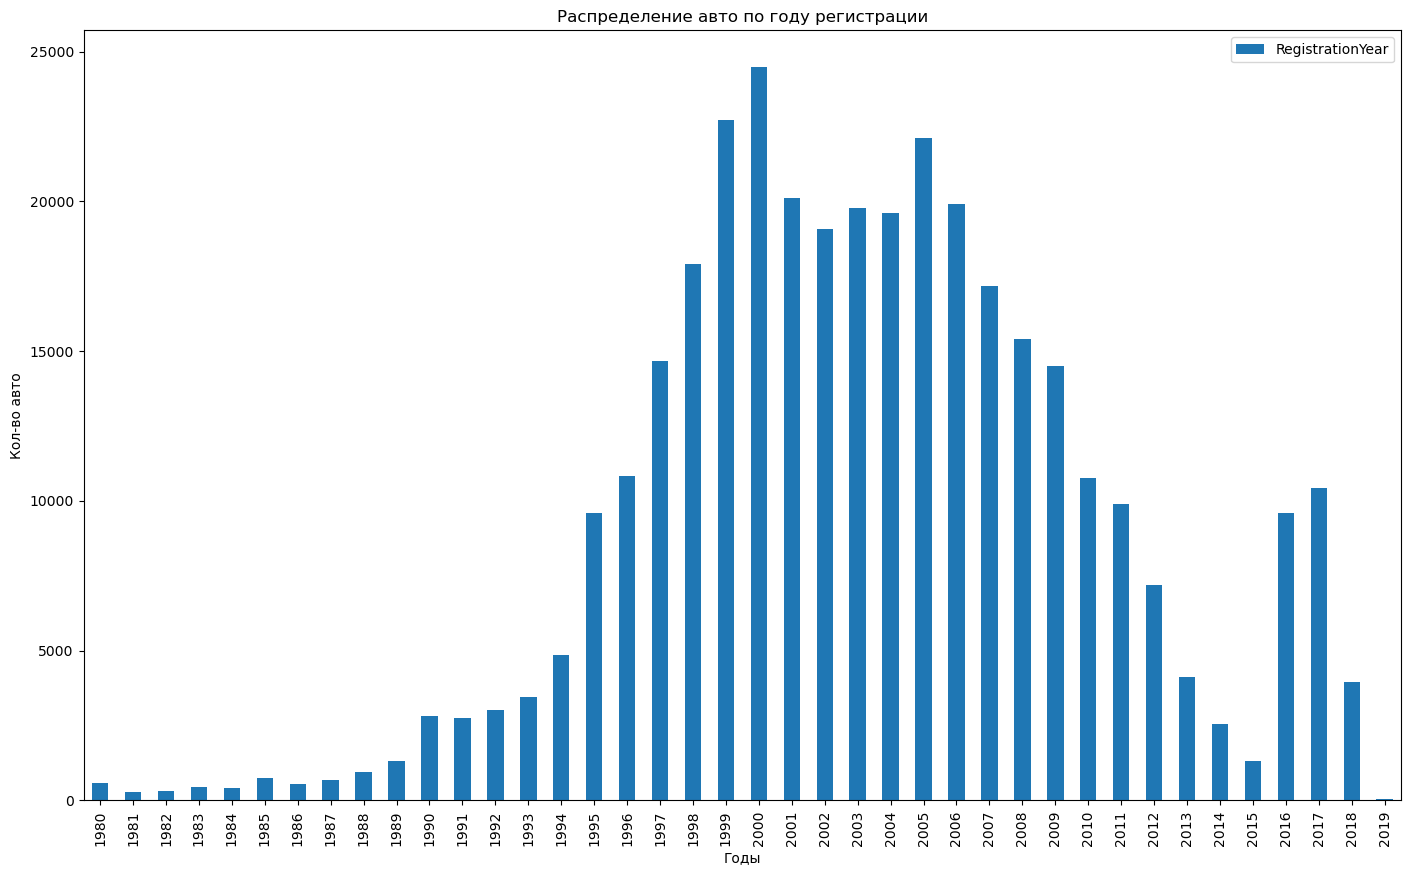

In [40]:
print(df['RegistrationYear'].describe(percentiles=[0.01, 0.25, .5]))
print(df['RegistrationYear'].sort_values().unique())
(t:=df['RegistrationYear'].value_counts().sort_index().to_frame()).loc[1980:2019].plot(
    kind='bar',
    figsize=(17,10),
    title='Распределение авто по году регистрации',
    xlabel='Годы',
    ylabel = 'Кол-во авто'
    
);
t.query('RegistrationYear>5000').sum()

Посмотрев на уникальные значения дат я отсёк сверху по 2019 году, так как за 2020 записей нет, а снизу по 1% перцентилю. При этом на графике видно что за 2019 записей крайне мало, так что и его можно отсечь.

In [42]:
df = df.query('1980<=RegistrationYear<@date_crawled.year')

***

In [44]:
df["FuelType"].value_counts()

petrol      202956
gasoline     94927
lpg           5049
cng            526
hybrid         216
other          158
electric        85
Name: FuelType, dtype: int64

Так как petrol и gasoline  одно и тоже то перреименую gasoline в petrol.

In [46]:
df.loc[df["FuelType"]=='gasoline',"FuelType"] = "petrol"

***

In [48]:
print(df['Gearbox'].unique(), f'Пропусков {df["Gearbox"].isna().mean():.2%}')
df['Gearbox'].value_counts()

['manual' 'auto' nan] Пропусков 4.86%


manual    248253
auto       62661
Name: Gearbox, dtype: int64

count    326788.000000
mean        112.284402
std         180.916863
min           0.000000
1%            0.000000
50%         105.000000
99%         300.000000
max       20000.000000
Name: Power, dtype: float64


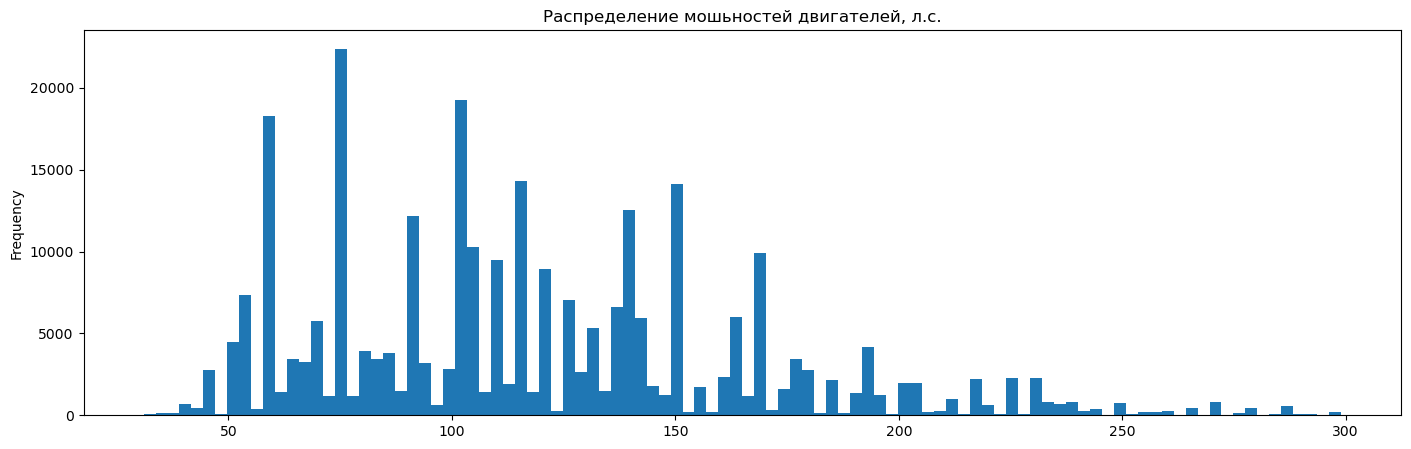

In [49]:
print(df["Power"].describe(percentiles=([.01,.5, .99])))
df.query('30<Power<300')["Power"].plot(
    kind='hist', 
    bins=100, 
    title ='Распределение мошьностей двигателей, л.с.',
);

In [50]:
df = df.query('30<Power<300')

count    290136.000000
mean       4712.344921
std        4551.400979
min           0.000000
25%        1250.000000
50%        3000.000000
75%        6899.000000
max       20000.000000
Name: Price, dtype: float64


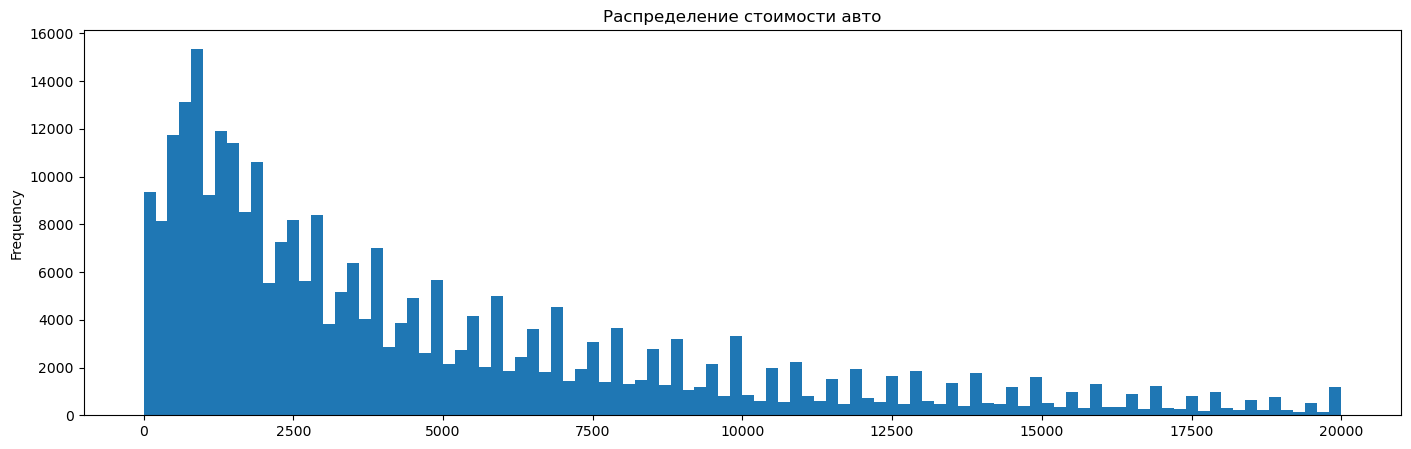

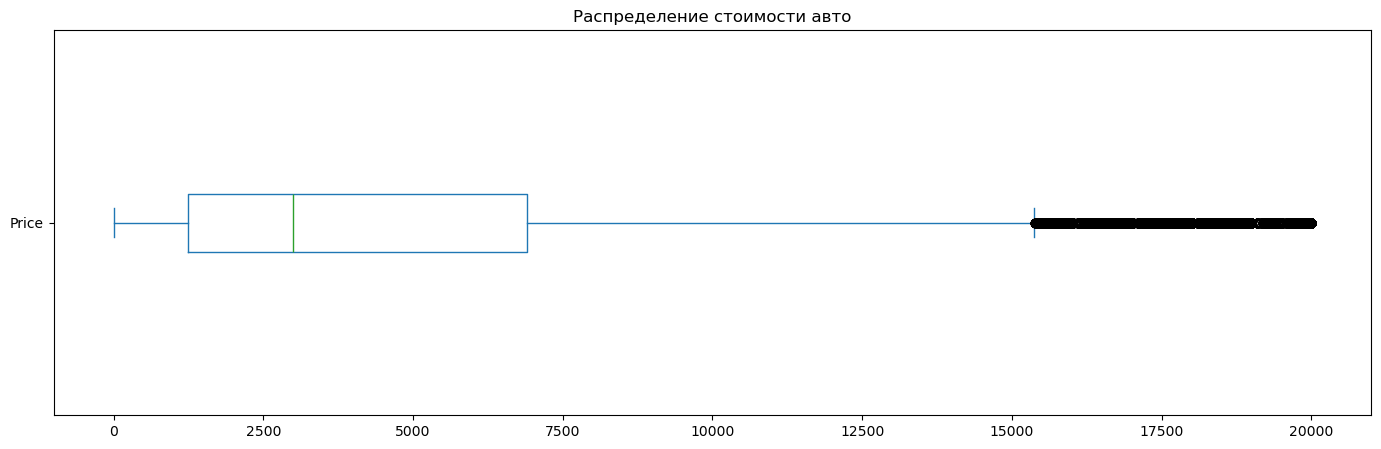

In [51]:
print(df['Price'].describe())
df['Price'].plot(kind='hist', bins=100, title='Распределение стоимости авто');
plt.show()
df['Price'].plot(kind='box', vert=False, title='Распределение стоимости авто');

В целевом признаки можно удалить выбросы по правому усу боксплота. А также нулевые значения.

In [53]:
r_mustache = 1.5*(df['Price'].quantile(.75) - df['Price'].quantile(.25)) + df['Price'].quantile(.75)
df = df.query('0 < Price < @r_mustache')

***

13
[125000 150000  90000  30000 100000  60000   5000  70000  80000  50000
  40000  20000  10000]


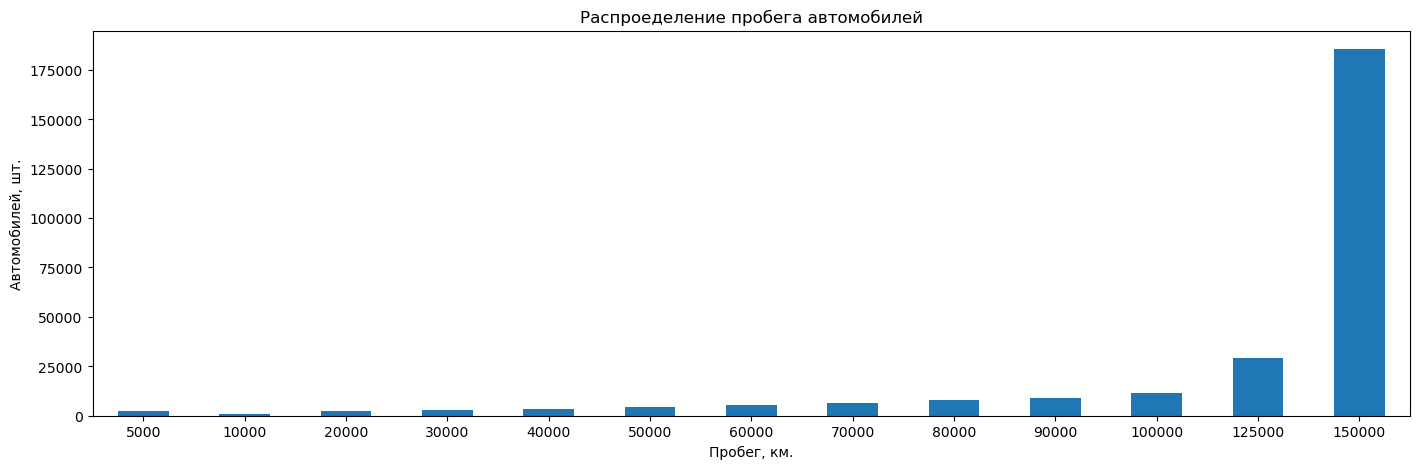

In [55]:
print(df["Kilometer"].nunique())
print(df["Kilometer"].unique())
df["Kilometer"].value_counts().sort_index().plot(
    kind='bar',
    title ="Распроеделение пробега автомобилей",
    xlabel='Пробег, км.',
    ylabel = 'Автомобилей, шт.',
    rot=0
);

In [56]:
print(df["Repaired"].isna().mean())
df["Repaired"].value_counts()

0.14253013999087336


no     205582
yes     27420
Name: Repaired, dtype: int64

***

In [58]:
df.dropna().shape

(217345, 10)

Даже если просто избавится от всех пропусков размер данных всё ещё останется довольно большим, поэтому так и поступлю

In [60]:
df = df.dropna()

Проверка на новые явные дубликаты

In [62]:
df.duplicated().sum()

34239

In [63]:
df = df.drop_duplicates()

In [64]:
df.shape

(183106, 10)

Окончательный размер данных.

## Обучение моделей

### Предобработка

In [68]:
ord_cols = ['VehicleType', 'Model', 'FuelType', 'Brand']
ohe_cols = ['Gearbox', 'Repaired'] 
trans = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(drop='first'), ohe_cols),
        ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1
         ), ord_cols)
    ], 
    remainder='passthrough'
)
cols = df.drop('Price', axis=1).columns
df_boost = pd.DataFrame(
    trans.fit_transform(
        df.drop('Price', axis=1)
    ),
    columns=ohe_cols+ord_cols+['RegistrationYear', 'Power', 'Kilometer']

)

Категориальные признаки закодированны.

In [70]:
df_boost

,Gearbox,Repaired,VehicleType,Model,FuelType,Brand,RegistrationYear,Power,Kilometer
0,1.0,0.0,5.0,116.0,5.0,37.0,2001.0,75.0,150000.0
1,1.0,0.0,5.0,101.0,5.0,31.0,2008.0,69.0,90000.0
2,1.0,1.0,4.0,11.0,5.0,2.0,1995.0,102.0,150000.0
3,1.0,0.0,1.0,8.0,5.0,25.0,2004.0,109.0,150000.0
4,1.0,0.0,4.0,10.0,5.0,19.0,2004.0,105.0,150000.0
...,...,...,...,...,...,...,...,...,...
183101,1.0,0.0,4.0,28.0,5.0,1.0,1997.0,150.0,150000.0
183102,0.0,1.0,4.0,95.0,5.0,20.0,2003.0,260.0,150000.0
183103,1.0,1.0,4.0,140.0,5.0,30.0,2004.0,225.0,150000.0
183104,0.0,0.0,1.0,106.0,5.0,32.0,2000.0,101.0,125000.0


### Подготовка выборок


In [72]:
X_train, X_test, y_train, y_test = train_test_split(
    df_boost,
    df['Price'],
    train_size = 0.8,
    random_state=RANDOM_STATE,
    shuffle = True
)

Восстановление порядка индексов

In [74]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


In [75]:
X_train

,Gearbox,Repaired,VehicleType,Model,FuelType,Brand,RegistrationYear,Power,Kilometer
0,0.0,0.0,7.0,170.0,5.0,37.0,2002.0,131.0,150000.0
1,1.0,0.0,0.0,150.0,5.0,24.0,2005.0,101.0,150000.0
2,1.0,0.0,5.0,83.0,5.0,24.0,1996.0,45.0,125000.0
3,1.0,0.0,4.0,59.0,5.0,20.0,1994.0,122.0,150000.0
4,1.0,0.0,5.0,173.0,5.0,37.0,2011.0,86.0,40000.0
...,...,...,...,...,...,...,...,...,...
146479,0.0,1.0,6.0,218.0,5.0,37.0,2005.0,174.0,150000.0
146480,1.0,0.0,2.0,76.0,3.0,20.0,2002.0,188.0,150000.0
146481,0.0,1.0,6.0,206.0,5.0,15.0,2005.0,140.0,150000.0
146482,1.0,1.0,4.0,149.0,5.0,27.0,1999.0,90.0,150000.0


### LightGBM

Модель с дефолтными гиперпарметрами.

In [78]:
%%time
lgbm = LGBMRegressor(random_state=RANDOM_STATE)
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 528
[LightGBM] [Info] Number of data points in the train set: 146484, number of used features: 9
[LightGBM] [Info] Start training from score 4653.254963
CPU times: total: 1.66 s
Wall time: 552 ms


LGBMRegressor(random_state=0)

In [79]:
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=RANDOM_STATE)
n_scores = cross_val_score(lgbm, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')

RMSE на кросс валидации

In [81]:
abs(n_scores.mean())

1439.29415497225

### Optuna

In [83]:
param_dist = {
    'n_estimators': distributions.IntDistribution(10, 150),
    'num_leaves': distributions.IntDistribution(1, 20),
    'max_depth': distributions.IntDistribution(-1, 10),
}
lgbm_optuna = OptunaSearchCV(
    LGBMRegressor(random_state=RANDOM_STATE),
    param_dist,
    cv = 5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scoring = 'neg_root_mean_squared_error',
    n_trials=100
    
)

C:\Users\user\AppData\Local\Temp\ipykernel_5504\150832101.py:6: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  lgbm_optuna = OptunaSearchCV(


In [84]:
%%time
lgbm_optuna.fit(X_train, y_train)

[I 2024-08-11 15:36:02,507] A new study created in memory with name: no-name-ad980a28-0e7c-4635-a57f-812ef6a4ad44
[I 2024-08-11 15:36:05,344] Trial 3 finished with value: -2394.3034752599983 and parameters: {'n_estimators': 12, 'num_leaves': 5, 'max_depth': 9}. Best is trial 3 with value: -2394.3034752599983.
[I 2024-08-11 15:36:07,413] Trial 13 finished with value: -2049.313286878676 and parameters: {'n_estimators': 20, 'num_leaves': 6, 'max_depth': 6}. Best is trial 13 with value: -2049.313286878676.
[I 2024-08-11 15:36:08,511] Trial 6 finished with value: -1918.053888281845 and parameters: {'n_estimators': 43, 'num_leaves': 20, 'max_depth': 2}. Best is trial 6 with value: -1918.053888281845.
[I 2024-08-11 15:36:09,018] Trial 0 finished with value: -1883.038638140498 and parameters: {'n_estimators': 28, 'num_leaves': 20, 'max_depth': 3}. Best is trial 0 with value: -1883.038638140498.
[I 2024-08-11 15:36:09,680] Trial 16 finished with value: -1986.954865744742 and parameters: {'n_est

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 528
[LightGBM] [Info] Number of data points in the train set: 146484, number of used features: 9
[LightGBM] [Info] Start training from score 4653.254963
CPU times: total: 8min 29s
Wall time: 2min 13s


OptunaSearchCV(cv=5, estimator=LGBMRegressor(random_state=0), n_jobs=-1,
               n_trials=100,
               param_distributions={'max_depth': IntDistribution(high=10, log=False, low=-1, step=1),
                                    'n_estimators': IntDistribution(high=150, log=False, low=10, step=1),
                                    'num_leaves': IntDistribution(high=20, log=False, low=1, step=1)},
               random_state=0, scoring='neg_root_mean_squared_error')

In [85]:
print(f'Лучший результат RMSE: {(lgbm_best_score := abs(lgbm_optuna.best_score_)):.2f}')

Лучший результат RMSE: 1458.77


In [86]:
lgbm_best_model = lgbm_optuna.best_estimator_

Сохраняю лучшую модель

In [88]:
t_start = time()
lgbm_best_model.fit(X_train, y_train)
t_end = time()

lgbm_best_model_fit_time = t_end - t_start

t_start = time()
lgbm_best_model.predict(X_train)
t_end = time()

lgbm_best_model_predict_time = t_end - t_start
print(f'''Лучшая модель:

Время обучения {lgbm_best_model_fit_time:.2f} сек.
Время предсказания {lgbm_best_model_predict_time:.2f} сек.
RMSE: {lgbm_best_score:.2f}
''')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 528
[LightGBM] [Info] Number of data points in the train set: 146484, number of used features: 9
[LightGBM] [Info] Start training from score 4653.254963
Лучшая модель:

Время обучения 0.47 сек.
Время предсказания 0.31 сек.
RMSE: 1458.77



### Дерево

In [90]:
%%time
tree = DecisionTreeRegressor(random_state = RANDOM_STATE)
tree.fit(X_train, y_train)


CPU times: total: 688 ms
Wall time: 517 ms


DecisionTreeRegressor(random_state=0)

Дерево, что логично, обучается быстрее градиентного бустинга который по своей сути является ансамблем деревьев. .

#### Дерево с оптимизацией гиперпараметров

In [93]:
param_dist = {
    'min_samples_split': distributions.IntDistribution(2, 20),
    'min_samples_leaf': distributions.IntDistribution(1, 20),
    'max_depth': distributions.IntDistribution(2, 10),
    'max_features': distributions.IntDistribution(2, 10)
}
tree_optuna = OptunaSearchCV(
    DecisionTreeRegressor(random_state=RANDOM_STATE),
    param_dist,
    cv = 5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scoring = 'neg_root_mean_squared_error',
    n_trials=100
    
)

C:\Users\user\AppData\Local\Temp\ipykernel_5504\2901186378.py:7: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  tree_optuna = OptunaSearchCV(


In [94]:
tree_optuna.fit(X_train, y_train)

[I 2024-08-11 15:38:17,459] A new study created in memory with name: no-name-1ffce523-4907-46fd-9a5f-8eb8e7842c10
[I 2024-08-11 15:38:18,586] Trial 8 finished with value: -2438.5512689740854 and parameters: {'min_samples_split': 8, 'min_samples_leaf': 3, 'max_depth': 3, 'max_features': 3}. Best is trial 8 with value: -2438.5512689740854.
[I 2024-08-11 15:38:18,958] Trial 4 finished with value: -2013.859795680696 and parameters: {'min_samples_split': 12, 'min_samples_leaf': 18, 'max_depth': 6, 'max_features': 3}. Best is trial 4 with value: -2013.859795680696.
[I 2024-08-11 15:38:18,975] Trial 12 finished with value: -2670.5891027623065 and parameters: {'min_samples_split': 7, 'min_samples_leaf': 1, 'max_depth': 2, 'max_features': 3}. Best is trial 4 with value: -2013.859795680696.
[I 2024-08-11 15:38:19,012] Trial 5 finished with value: -2419.209318127613 and parameters: {'min_samples_split': 17, 'min_samples_leaf': 6, 'max_depth': 3, 'max_features': 6}. Best is trial 4 with value: -20

OptunaSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=0), n_jobs=-1,
               n_trials=100,
               param_distributions={'max_depth': IntDistribution(high=10, log=False, low=2, step=1),
                                    'max_features': IntDistribution(high=10, log=False, low=2, step=1),
                                    'min_samples_leaf': IntDistribution(high=20, log=False, low=1, step=1),
                                    'min_samples_split': IntDistribution(high=20, log=False, low=2, step=1)},
               random_state=0, scoring='neg_root_mean_squared_error')

In [95]:
tree_optuna.best_estimator_

DecisionTreeRegressor(max_depth=10, max_features=8, min_samples_leaf=17,
                      min_samples_split=8, random_state=0)

In [96]:
print(tree_best_score := abs(tree_optuna.best_score_))

1679.8463368416917


In [97]:
tree_best_model = tree_optuna.best_estimator_

t_start = time()
tree_best_model.fit(X_train, y_train)
t_end = time()

tree_best_model_fit_time = t_end - t_start

t_start = time()
tree_best_model.predict(X_train)
t_end = time()

tree_best_model_predict_time = t_end - t_start
print(f'''Лучшая модель:

Время обучения {tree_best_model_fit_time:.2f} сек.
Время предсказания {tree_best_model_predict_time:.2f} сек.
RMSE: {tree_best_score:.2f}
''')

Лучшая модель:

Время обучения 0.22 сек.
Время предсказания 0.02 сек.
RMSE: 1679.85



***
## Анализ моделей

Я сравнил две модели: Решающее дерево и Градиентный бустинг. Время обучения бустинга намного дольше и напрямую зависит от кол-ва деревьев входящих в него, равно как и от других гиперпараметров влияющих на скорость обучения каждого конкретного дерева.  
Что касается качества то тут бустинг показывает лучшие результаты метрики RMSE.  
В данном случае, так-как обе модели удовлетворяют условиям качества метрики, можно выбрать модель Решающего дерева, однако если точность предсказаний всё-таки важнее качества то нужно выбирать модель Градиентного бустинга.

Также сравню модели с константным предсказателем.

In [101]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
preds = dummy.predict(X_test)
mean_squared_error(y_test, preds, squared=False)


3791.7955974022857

Результаты моделей намного лучше результатов константного предсказателя.

In [103]:
wide = 7
print(f'''Сравнение двух моделей:
                       | Tree  | LGBM  |
Время обучения, c.     |{tree_best_model_fit_time:^{wide}.2f}|{lgbm_best_model_fit_time:^{wide}.2f}|
Время предсказания, c. |{tree_best_model_predict_time:^{wide}.2f}|{lgbm_best_model_predict_time:^{wide}.2f}|
RMSE:                  |{tree_best_score:^{wide}.2f}|{lgbm_best_score:^{wide}.2f}|
''')

Сравнение двух моделей:
                       | Tree  | LGBM  |
Время обучения, c.     | 0.22  | 0.47  |
Время предсказания, c. | 0.02  | 0.31  |
RMSE:                  |1679.85|1458.77|



Как видно по результатам сравнения дерево не сильно проигрывает в качестве метрики но значительно превосходит в скорости обучения и предсказания поэтому будет выбрана именно она.
***

Оценка лучшей модели на тестовой выборке:

In [105]:
t_start = time()
preds = tree_optuna.predict(X_test) 
t_end = time()
rmse = mean_squared_error(y_test, preds, squared=False)
print(f'RMSE лучшей модели на тестовых данных: {rmse:.2f}\nВремя предсказания: {1000*(t_end-t_start):.2f} мс.')

RMSE лучшей модели на тестовых данных: 1662.53
Время предсказания: 7.00 мс.


## Вывод:
После построения различных моделей определяющих стоимость подержанного автомобилей были проведены их сравнения по метрике RMSE, скорости обучения и скорости предсказания.
По результатам сравнения **оптимальной по параметрам была выбрана модель DecisionTreeRegressor**, так-как из качеств моделей важных заказчику в сравнении с градиентным бустингом она:
 - В скорости обучения превосходит двукратно
 - В скорости предсказания превосходит значительно
 - В качестве предсказания не сильно уступает